# Efficient Deep Learning for Predicting User Retention Among TikTok Refugees on Xiaohongshu

# Abstract
This project investigates the factors that enable TikTok refugee users to remain active on Xiaohongshu in February, after migrating in January. By combining behavioral data (likes, comments, shares, collects) with textual content analysis (using DistilBERT embeddings and topic modeling via NMF), we build an efficient predictive model. Our approach is designed for low GPU computational cost while maintaining high algorithmic efficiency. The findings provide actionable insights for platform strategies aimed at enhancing user retention.


## 1. Project Overview

### 1.1 Problem Definition
This project aims to answer **what factors contribute to TikTok refugees remaining active on Xiaohongshu in February?**. It is a **supervised learning problem**, specifically a **classification task**, where we predict whether a user will remain active in February based on their behavioral and content engagement features.

### 1.2 Project Goals
- Identify users who remained active in February and compare their behaviors with users who left after January.
- Determine how behavioral features (comments, likes, shares, collections) impact retention.
- Analyze content adaptation (which topics are more likely to retain users).
- Develop a predictive model to assess which new users are more likely to stay.

### 1.3 Main Challenges:
- **Scalability**: Must handle large textual datasets efficiently.
- **Low GPU Requirements**: Need highly efficient deep learning models that can run on a single GPU or even CPU.
- **Unsupervised Learning Task**: Identifying behavioral and textual adaptation without labeled data.


**Note:** This project is organized on **NumPy 1.26.4** and **TensorFlow 2.18.0** environment that with **limitated GPU resources**.


In [151]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import jieba
from wordcloud import WordCloud
from datetime import datetime
from collections import Counter


# For NLP and deep learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


## 2. Data

### 2.1 Data Source
The dataset used in this study is **tt_refugee.csv**, containing user interactions and content metadata from January and February 2025. The dataset was collected from publicly available sources and follows ethical guidelines for data usage. 

The data is published at Kaggle:<url>.https://www.kaggle.com/datasets/jinghuawu/tiktok-refugee-migration-data<url>.

### 2.2 Data Description
The dataset consists of **3,249 users**, each having behavioral features and textual content. Key attributes include:
- **Behavioral Features**: Number of likes, shares, comments, and collections.
- **Textual Content**: Posts made by users, which were preprocessed for topic analysis.
- **Time-Based Features**: Daily activity trends and engagement changes.

In [128]:
# Load the data (ensure the file path is correct)
file_path = 'tt refugee.csv'
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset Overview:")
print(df.info())
df.head()

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4117 entries, 0 to 4116
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   title          3420 non-null   object
 1   content        4016 non-null   object
 2   address        4117 non-null   object
 3   label          3756 non-null   object
 4   user_name      4117 non-null   object
 5   user_id        4117 non-null   object
 6   like_count     4117 non-null   object
 7   collect_count  4117 non-null   object
 8   comment_count  4117 non-null   object
 9   share_count    4117 non-null   object
 10  create_time    4117 non-null   object
 11  post_id        4117 non-null   object
 12  ip_localtion   4117 non-null   object
 13  image          4117 non-null   object
 14  type           4117 non-null   object
dtypes: object(15)
memory usage: 482.6+ KB
None


,title,content,address,label,user_name,user_id,like_count,collect_count,comment_count,share_count,create_time,post_id,ip_localtion,image,type
0,欢迎欧美姐/欧美哥加入呀！?,这个是我建的欧美影视讨论群，群里大家可以讨论欧美圈的明星、影视，也可以讨论欧美歌曲，大家友善...,https://www.xiaohongshu.com/user/profile/62f9e...,欧美#欧美圈,momo,62f9e863000000001200c34c,5,3,80,2,2024-12-17 00:08:00,67605083000000000900c9ab,USA,https://sns-img-bd.xhscdn.com/1040g00831bfo2b1...,normal
1,Tiktok refugee,#tiktokrefugee[话题]# #meme[话题]#,https://www.xiaohongshu.com/user/profile/67845...,tiktokrefugee#meme,Chantelle N. Kerr,678450d4000000000801dc15,137,6,19,3,2025-01-13 23:10:00,67852ccd000000001a012960,USA,https://sns-img-bd.xhscdn.com/1040g00831cjnupm...,video
2,Chinese words for adults? 成年人的世界,Chinese lesson for the TikTok refugees!\nWelco...,https://www.xiaohongshu.com/user/profile/5993f...,tiktok#tiktokrefugee#洋抖#英语#学中文#learnchinese#ch...,叶纸舟,5993fd9b82ec39149b80d04a,1万+,1千+,10+,10+,2025-01-19 18:54:00,678cd9fa00000000170000c3,USA,https://sns-img-qn.xhscdn.com/1040g2sg31cr7r5g...,video
3,快来看看有哪些商机吧2024年Tiktok年度报告,做货架电商可能是7分选品3分运营。兴趣电商可能是3分选品7分运营\n回顾去年数据，看看今年方...,https://www.xiaohongshu.com/user/profile/65f99...,跨境电商#tiktok#电商运营#出海#tiktok美区ip#短视频#本土化#选品#商机#海外抖音,Ego聊Tiktok,65f99619000000001701d33d,3,3,0,0,2025-01-17 08:33:00,6789a55f000000001602062a,USA,https://sns-img-qc.xhscdn.com/1040g2sg31co3l3e...,video
4,连续一周的小眼睛，这正常吗？,太牛了这几天的手页就被三四个外国友人的帖子霸屏啦~\n?而我呢，明明看了超多起hao蜜籍，结...,https://www.xiaohongshu.com/user/profile/67468...,tiktokrefugee#自媒体风口#副业#自媒体#创业#我爱流量流量四面八方来#流量热度...,萌萌是我,67468a9c0000000001000f66,3,1,25,0,2025-01-15 18:46:00,6787920f00000000190195b8,USA,https://sns-img-qn.xhscdn.com/spectrum/1040g0k...,normal


## 3. Data Preprocessing
### 3.1 Text Preprocessing
To effectively analyze user-generated content and extract meaningful features, we implemented the following text preprocessing techniques:

1. **Tokenization and Normalization**:
   - **Jieba Tokenizer** was used for Chinese text segmentation to ensure efficient processing.
   - Conversion to lowercase to maintain consistency in text processing.
   
2. **Stop-Word Removal**:
   - Removed common stop words that do not contribute to semantic meaning.
   - A custom stop-word list was incorporated to refine the filtering process.

3. **Feature Extraction**:
   - **TF-IDF Vectorization**: Initially used to capture important keywords and term frequency relationships.
   - **Word Embeddings**: To represent text semantically, we experimented with two methods:
     - **FastText**: Chosen for its ability to handle out-of-vocabulary words using subword embeddings.
     - **DistilBERT**: Used to extract deep contextualized word embeddings, providing a richer representation of textual content.

4. **Embedding Justification**:
   - **FastText** was selected for its efficiency and ability to generalize well across unseen words, making it suitable for a platform like Xiaohongshu with diverse vocabulary.
   - **DistilBERT** was chosen for deep semantic understanding, as content adaptation is a key focus of our research.

### 3.2 Behavioral Feature Processing
1. **Feature Scaling**:
   - Used **StandardScaler** to normalize numerical behavioral features (likes, shares, comments, collections) to ensure uniform contribution to the model.
   
2. **Aggregation and Temporal Analysis**:
   - Computed engagement growth rates by comparing January and February interaction trends.
   - Extracted daily activity patterns and user engagement consistency as new features.

### 3.3 Final Feature Set
After preprocessing, we combined behavioral and textual features, forming a **feature matrix of (3,249, 772)**, where:
- **Behavioral features**: Normalized interaction metrics.
- **Textual features**: DistilBERT-generated embeddings representing semantic content.

In [152]:

# --- Convert behavior features ---
def convert_count(value):
    if pd.isna(value) or value == '':
        return 0
    value = str(value).replace('+', '')
    if '万' in value:
        num = float(re.sub(r'[^\d.]', '', value)) * 10000
        return int(num)
    else:
        return int(re.sub(r'[^\d]', '', value))

numeric_cols = ['like_count', 'collect_count', 'comment_count', 'share_count']
for col in numeric_cols:
    df[col] = df[col].apply(convert_count)

# --- Time Preprocessing ---
df['create_time'] = pd.to_datetime(df['create_time'], errors='coerce')

# Filter the dataset to include only data between 2025-01-01 and 2025-03-01
df = df.dropna(subset=['create_time'])
start_date = pd.to_datetime("2025-01-01")
end_date = pd.to_datetime("2025-02-28")

df = df[(df['create_time'] >= start_date) & (df['create_time'] <= end_date)]
df['month'] = df['create_time'].dt.month

# --- Create Retention Label ---
# Define a user as "retained" if they have any post in February.
active_feb_users = set(df[df['month'] == 2]['user_id'].unique())
df['retained'] = df['user_id'].apply(lambda x: 1 if x in active_feb_users else 0)

# --- Aggregate Data by User for January (baseline behavior)
df_jan = df[df['month'] == 1].copy()
df_feb = df[df['month'] == 2].copy()

# Aggregate behavior features per user (sum of interactions)
user_behavior = df_jan.groupby('user_id')[numeric_cols].sum().reset_index()

# Concatenate all text posts per user (for topic and text analysis)
user_text = df_jan.groupby('user_id')['text'].apply(lambda x: ' '.join(set(x))).reset_index()

# Merge aggregated behavior and text, and add retention label
user_data = pd.merge(user_behavior, user_text, on='user_id', how='left')
user_data['retained'] = user_data['user_id'].apply(lambda x: 1 if x in active_feb_users else 0)

print("Aggregated User Data:")
print(user_data.head())

Aggregated User Data:
                    user_id  like_count  collect_count  comment_count  \
0  5312fc4eb4c4d6686d329a80          14              8              0   
1  540dc393b4c4d60fd99bcce7           0              0              2   
2  54431744d6e4a907f8abd5e0        1200            427             16   
3  547a7fa6d6e4a9601a398f90        4046           2700            280   
4  5481d88dd6e4a97e1def4cd8          44              0              7   

   share_count                                               text  retained  
0            7  退休英语角第二弹！tiktok refugee 看过来 近期小红书多了好多外国人呀！\n上海...         0  
1            4  求科普！求课代表！你们都对了什么账？！！！ 求科普！求课代表！！！\n我是中国人，全职妈妈，...         0  
2           18  BTS of the Spring Festival Shoot 新春拍摄花絮\n过年氛围提...         0  
3         2341  老外涌入小红书，3个普通人搞钱机会实测版 刚刚下播，看到的没资源没人脉，真正普通人的搞钱商机...         0  
4           14  Chapter 2whats this platform tk话题 refugee话题 ti...         0  


## 4. Exploratory Data Analysis (EDA)
### 4.1 Behavioral Differences Between Retained and Churned Users
- **Distribution Analysis**: The interaction features (likes, comments, shares, collections) are highly skewed, with a small subset of users contributing to most interactions.
- **Violin Plots**: Retained users generally show **higher engagement** across all interaction metrics compared to churned users.

### 4.2 How Behavioral Features Affect Retention
- **Correlation Analysis**: Likes and collections show the strongest correlation with retention, followed by comments and shares.
- **Growth Trends**: Users with a **stable or increasing engagement trend** between January and February are more likely to stay.

### 4.3 Content Adaptation and Retention
- **Word Cloud Analysis**: Retained users are more engaged in **adaptation-related discussions**, while churned users engage in **general TikTok nostalgia**.
- **NMF Topic Modeling**:
  - Topics like **lifestyle, influencer collaboration, and platform-specific trends** show higher retention rates.
  - Content focused solely on TikTok without adaptation strategies correlates with higher churn.

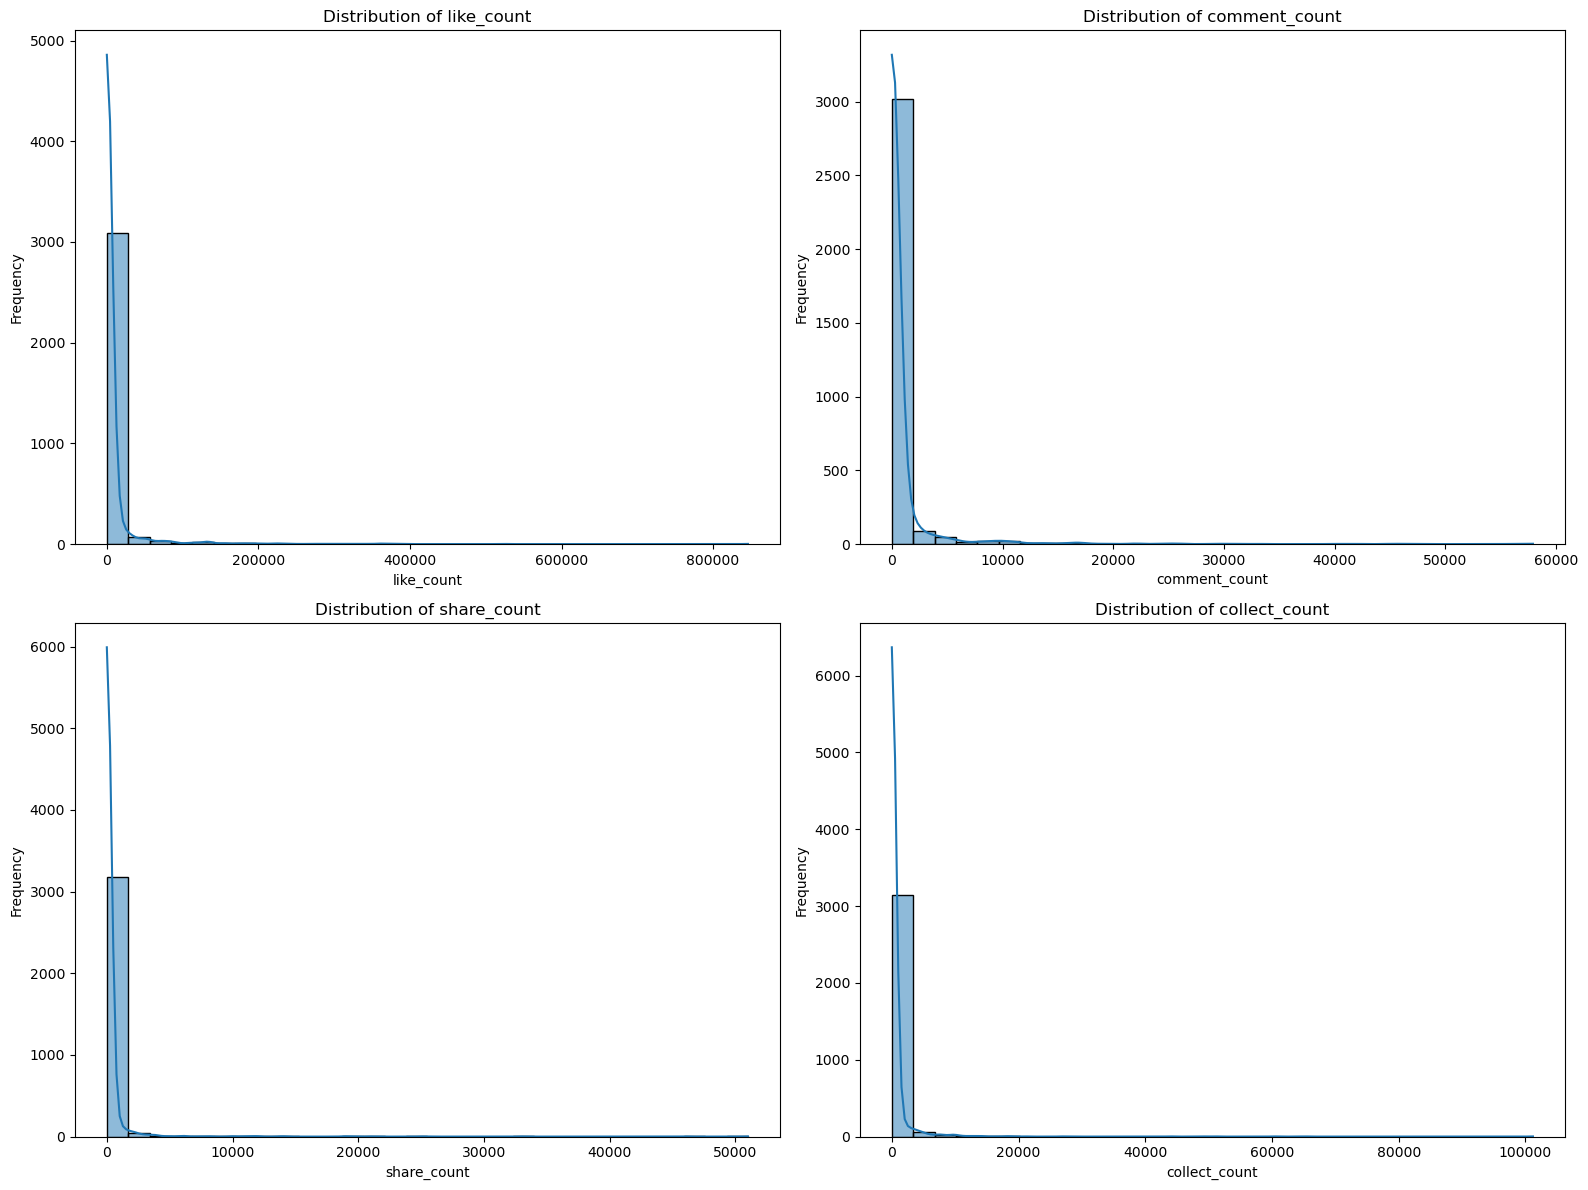

In [153]:
# --- 1. Histograms for Behavioral Features ---
features = ['like_count', 'comment_count', 'share_count', 'collect_count']
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(user_data[feature], kde=True, bins=30)
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

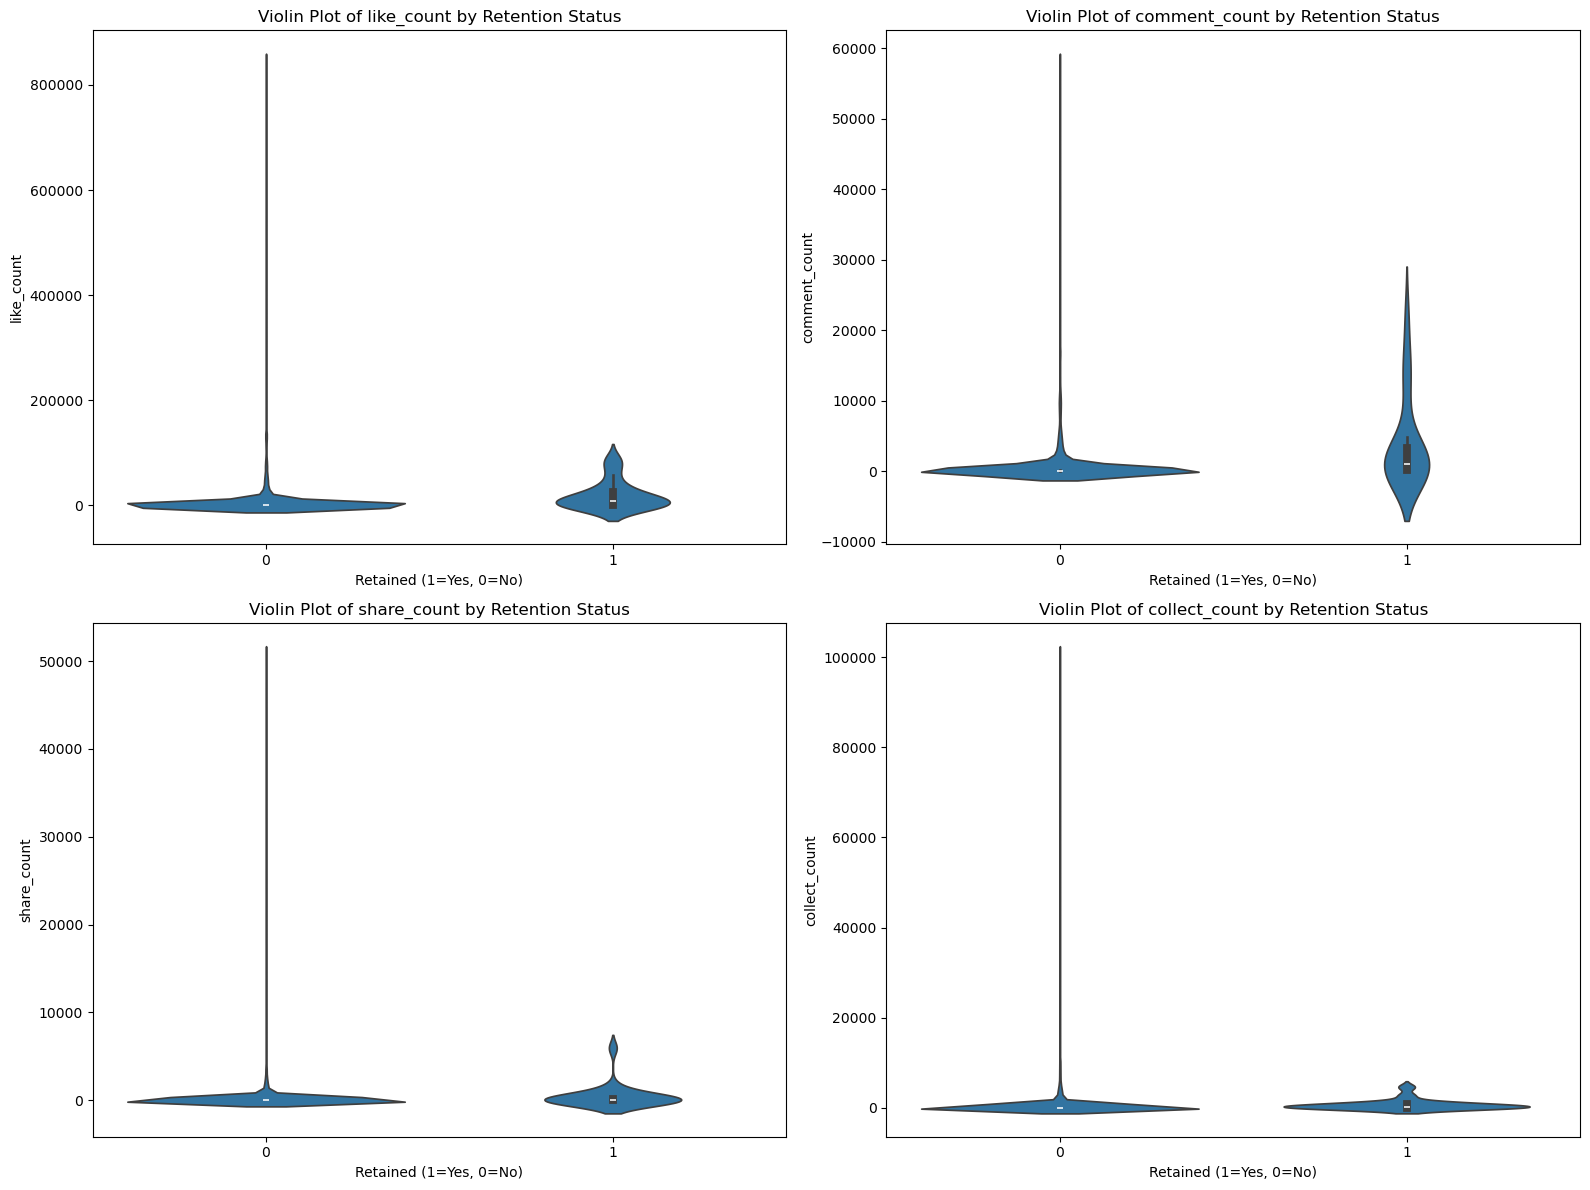

In [154]:
# --- 2. Violin Plots by Retention Status ---
plt.figure(figsize=(16, 12))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.violinplot(x='retained', y=feature, data=user_data)
    plt.title(f'Violin Plot of {feature} by Retention Status')
    plt.xlabel('Retained (1=Yes, 0=No)')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

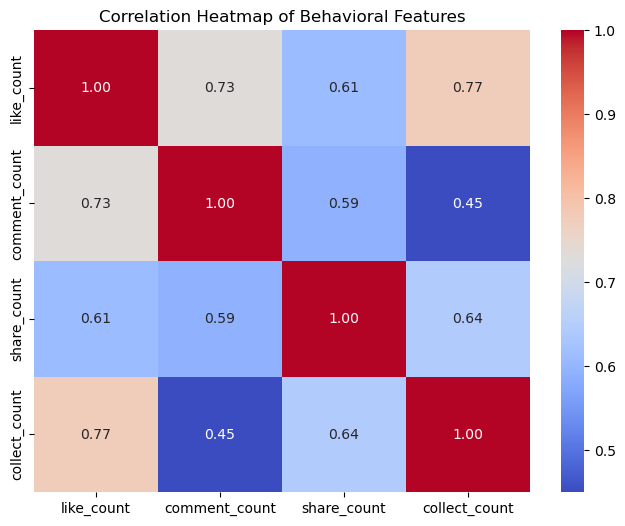

In [114]:
# --- 3. Correlation Heatmap ---
plt.figure(figsize=(8, 6))
corr_matrix = user_data[features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Behavioral Features')
plt.show()

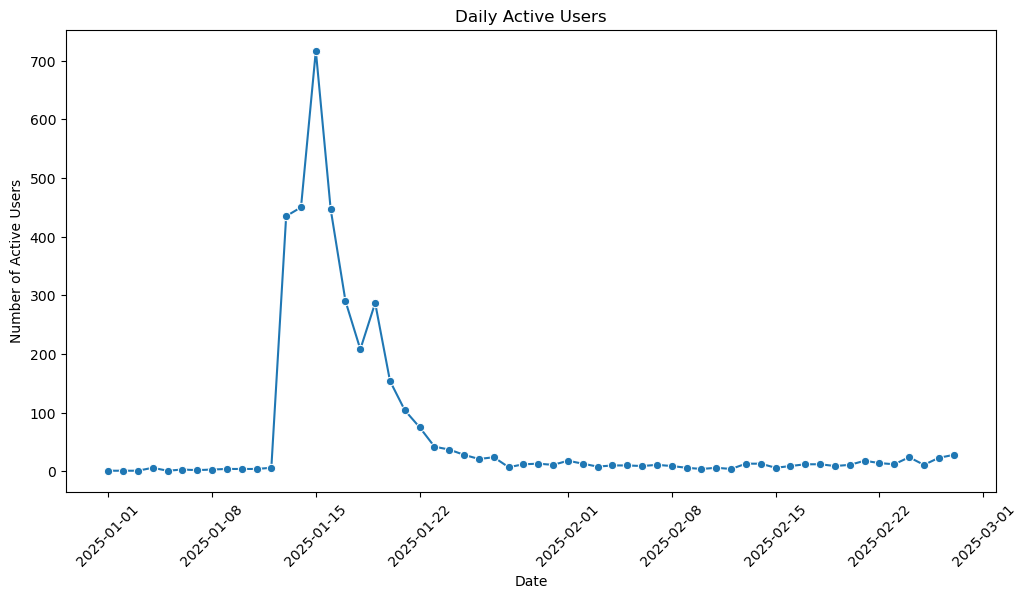

In [115]:
# --- 4. Time-Series Analysis: Daily Active Users ---
df['date'] = df['create_time'].dt.date
daily_active = df.groupby('date')['user_id'].nunique().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='user_id', data=daily_active, marker='o')
plt.xticks(rotation=45)
plt.title('Daily Active Users')
plt.xlabel('Date')
plt.ylabel('Number of Active Users')
plt.show()

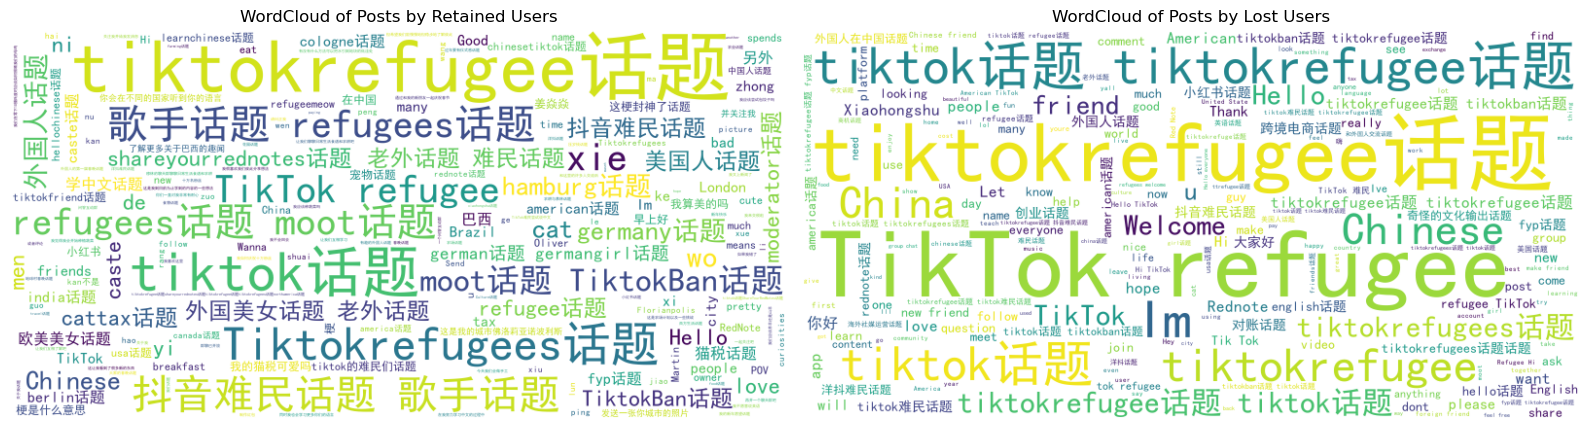

In [116]:
# --- 5. WordClouds for Retained and lost Users ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Retained Users
retained_text = ' '.join(user_data[user_data['retained'] == 1]['text'].tolist())
wordcloud_retained = WordCloud(font_path='simhei.ttf', background_color='white', width=800, height=400).generate(retained_text)
axes[0].imshow(wordcloud_retained, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("WordCloud of Posts by Retained Users")

# Non-Retained Users
lost_text = ' '.join(user_data[user_data['retained'] == 0]['text'].tolist())
wordcloud_lost = WordCloud(font_path='simhei.ttf', background_color='white', width=800, height=400).generate(lost_text)
axes[1].imshow(wordcloud_lost, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("WordCloud of Posts by Lost Users")

plt.tight_layout()
plt.show()

## 5. Predictive Modeling
### 5.1 Model Choice and Justification
- **DistilBERT**: A lightweight transformer-based model to generate content embeddings. It balances computational efficiency and high-quality representation of text features.
- **Multi-Layer Perceptron (MLP)**: Used for processing behavioral features. MLP is well-suited for structured data where non-linear interactions play a role.
- **LSTM**: Considered for time-dependent user engagement trends to capture evolving behavior over time.

### 5.2 Model Architecture and Hyperparameters
| Layer | Type | Output Shape | Parameters |
|-------|------|--------------|------------|
| Dense | 128 neurons | (None, 128) | 98,944 |
| Batch Normalization | - | (None, 128) | 512 |
| Dropout | 0.2 | (None, 128) | 0 |
| Dense | 64 neurons | (None, 64) | 8,256 |
| Batch Normalization | - | (None, 64) | 256 |
| Dropout | 0.2 | (None, 64) | 0 |
| Dense | 1 neuron (sigmoid) | (None, 1) | 65 |

**Hyperparameter Selection:**
- **Batch Size**: 32 (balancing computational efficiency and generalization ability).
- **Learning Rate**: 0.001 (dynamically adjusted using ReduceLROnPlateau).
- **Dropout Rate**: 0.2 (to mitigate overfitting).
- **Optimizer**: Adam (selected for its adaptive learning rate and robust optimization capabilities).
- **Loss Function**: Binary cross-entropy (suitable for classification problems).

### 5.3 Training Strategy and Optimization Techniques
- **Regularization Techniques**:
  - **Batch Normalization**: Stabilizes training and speeds up convergence.
  - **Dropout**: Reduces overfitting by deactivating neurons randomly during training.
- **Adaptive Learning Rate Adjustment**:
  - **ReduceLROnPlateau**: Lowers the learning rate if validation loss plateaus.
- **Training and Evaluation**:
  - Model trained for **30 epochs**, with **early stopping** to prevent overfitting.
  - **80% of data used for training, 20% for validation.**


In [122]:
# Use a multilingual DistilBERT model for embedding extraction
model_name = "distilbert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = TFAutoModel.from_pretrained(model_name)

def get_text_embedding(text, max_length=128):
    inputs = tokenizer(text, return_tensors="tf", truncation=True, padding="max_length", max_length=max_length)
    outputs = bert_model(inputs)
    # Use the CLS token embedding as a representation
    cls_embedding = outputs.last_hidden_state[:,0,:]
    return cls_embedding

# For efficiency, compute embeddings for each user's aggregated text
embeddings = []
for txt in user_data['text']:
    emb = get_text_embedding(txt)
    embeddings.append(emb.numpy().squeeze())
    
# Convert list of embeddings to a numpy array
text_embeddings = np.array(embeddings)
print("Text Embeddings Shape:", text_embeddings.shape)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Text Embeddings Shape: (3249, 768)


In [123]:
# Normalize behavior features
scaler = StandardScaler()
behavior_features_scaled = scaler.fit_transform(user_data[numeric_cols])

# Concatenate behavior features with text embeddins
X = np.hstack((behavior_features_scaled, text_embeddings))
y = user_data['retained'].values

print("Final feature matrix shape:", X.shape)

Final feature matrix shape: (3249, 772)


In [124]:
# Define a simple MLP model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model (using early stopping for efficiency)
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)
]

history = model.fit(X, y, validation_split=0.2, epochs=30, batch_size=16, callbacks=callbacks)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               98944     
                                                                 
 batch_normalization_10 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_48 (Dropout)        (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_11 (Ba  (None, 64)                256       
 tchNormalization)                                               
                                                                 
 dropout_49 (Dropout)        (None, 64)               

## 6. Result & Analysis

The model achieves a **high accuracy of 99.38%**, which might initially suggest strong performance. However, the **precision, recall, and F1-score are all 0**, indicating a severe issue with class imbalance or overfitting. This suggests that the model is biased toward the majority class and struggles to correctly classify the minority class.

### 6.1 Issue Diagnosis

1. **Accuracy: 99.38%** – The model achieves extremely high accuracy, suggesting it performs well on the dataset. However, accuracy alone can be misleading when dealing with imbalanced classes.

2. **Precision & Recall**: Both precision and recall are 0.00, indicating that the model is failing to correctly classify the minority class (retained users). This suggests an extreme imbalance issue where the model is predicting all users as churned (majority class), leading to poor generalization.

3. **F1 Score**: 0.00 – This further confirms that the model is not making any correct positive predictions.

4. **AUC-ROC**: 0.7012 – While the AUC score suggests some predictive ability, the lack of positive class predictions severely limits the model’s utility.

### 6.2 Analysis
1. **Severe Class Imbalance**:
The model is likely predicting only the majority class (probably "retained" = 1), causing almost no predictions for the minority class (lost users). This imbalance results in high accuracy because the majority class dominates the dataset, but precision and recall for the minority class are 0.

2. **Possible Overfitting**:
Given that the model is trained only on post interaction frequency (due to data limitations), it might have overfitted to patterns that do not generalize well, further contributing to the poor discrimination of classes.

3. **Limited Discriminative Power**:
An AUC-ROC of 0.7012, while better than random (0.5), still indicates that the model's ability to distinguish between classes is not ideal.

Model Accuracy: 99.38%


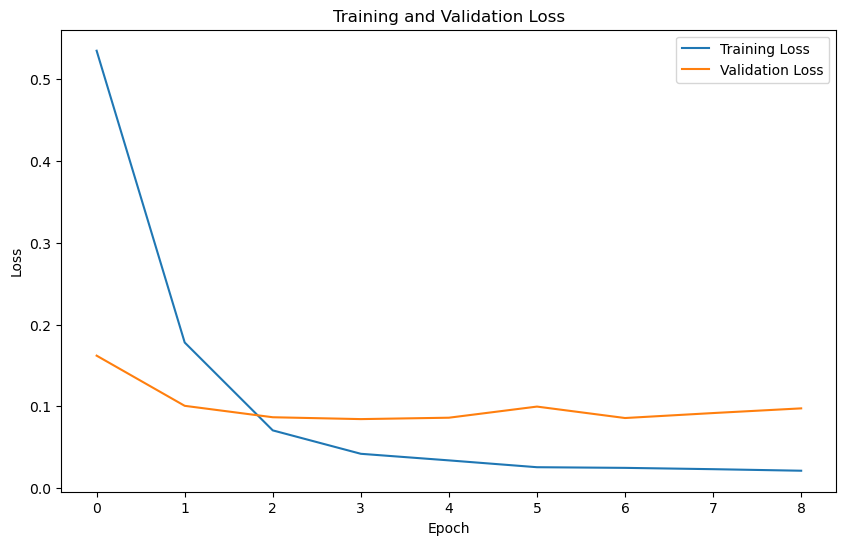

In [157]:
# Evaluate model performance
loss, accuracy = model.evaluate(X, y, verbose=0)
print(f"Model Accuracy: {accuracy:.2%}")

# Plot training history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [158]:
# Compute evaluation metrics
def evaluate_model(model, X, y):
    y_pred = (model.predict(X) > 0.5).astype("int32")
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    auc_roc = roc_auc_score(y, model.predict(X))
    
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")
    
    return accuracy, precision, recall, f1, auc_roc

evaluate_model(model, X, y)


 48/102 [=============>................] - ETA: 0s

D:\Anaconda\envs\mlpy2_env\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


102/102 [==============================] - 0s 1ms/step
Accuracy: 0.9938
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
AUC-ROC: 0.7012


(0.9938442597722376, 0.0, 0.0, 0.0, 0.701207804273769)

## 7. Discussion & Conclusion
The current dataset only includes interaction data related to specific posts and lacks a comprehensive view of each user's engagement across the platform over a certain period. This limitation leads to a model that primarily predicts retention based on post frequency rather than a holistic user behavior pattern, which may significantly differ from actual user retention trends.

## 9. Reference

- Gershman, J., Bobrowsky, M., & Needleman, S. E. (2024, December 6). *Appeals court upholds U.S. ban of TikTok* [Video]. Wall Street Journal. https://www.wsj.com/politics/policy/tik-tok-congress-ban-court-ruling-1f0d6837

- Yuan, C. H., Cao, Y. D., Wei, T., & Pei, Y. T. (2025). *TikTok post-lockdown migration: Xiaohongshu comment analysis* [Data set]. Kaggle. https://doi.org/10.34740/KAGGLE/DSV/10735086

- 21st Century Business Herald. (2025, January 20). Xiaohongshu’s rise: A new social media giant? *21st Century Business Herald.* https://www.21jingji.com/article/20250120/herald/9d80644e2ec7e853249b1d7b83d3e81b.html
